<center>
<h1>Znanstveno programiranje - projekt</h1>
<h2>Ak. god. 2025./2026.</h2>
<h3>Naziv: Detekcija abnormalnih vrijednosti koristeći AIS podatke</h3>
Studentica: Marija Karoglan
</center>

###Uvod u podatke i rad

Static Information :

    The ship's IMO number
    The ship's MMSI number
    The ship's Call Sign
    The ship's name
    The ship's type
    What type of destination this message was received from (like Class A / Class B)
    Width of ship
    Length of ship
    Draft of ship
    Type of GPS device
    Length from GPS to bow (Length A)
    Length from GPS to stern (Size B)
    Length from GPS to starboard (Size C)
    Length from GPS to port side (Dimension D)

Dynamic Data:

    Time information (31/12/2015 in 23:59:59 format)
    Latitude
    Longitude
    Navigational status (For example: 'Fishing', Anchored, etc.)
    Rate of Turn (ROT)
    Speed Over Ground (SOG)
    Course Over Ground (COG)
    Heading
    Type of cargo
    Port of Destination
    Estimated Time of Arrival (ETA)
    Data source type, eg. AIS




Skup podataka: https://www.kaggle.com/datasets/eminserkanerdonmez/ais-dataset

Praćeni rad:
A framework for ship abnormal behaviour detection and classification using AIS data - H. Rong, A.P. Teixeira, C. Guedes Soares
(https://www.sciencedirect.com/science/article/pii/S0951832024001790)

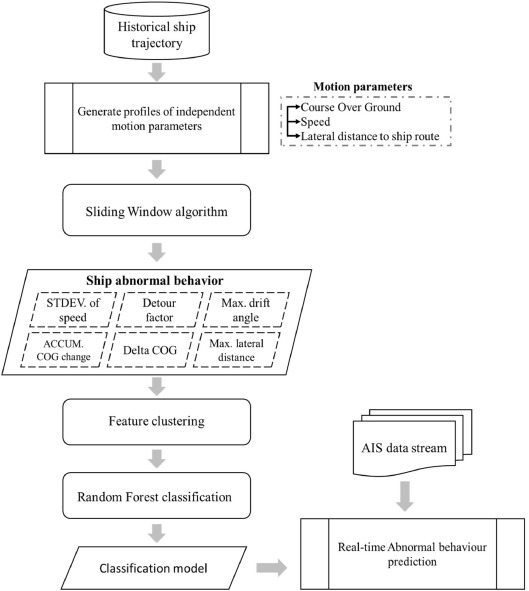

###Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from sklearn.cluster import DBSCAN
import math
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

###Pregled podataka

Učitavanje podataka:

In [2]:
data=pd.read_csv("ais_data.csv")

Korak iznad potrebno prilagoditi u ovisnosti gdje su podaci spremljeni (npr. staviti rutu u zagrade umjesto samo naziva datoteke).
Provjeravamo jesu li svi stupci koje je autor skupa podataka zapravo u skupu:

In [ ]:
data.columns

Index(['Unnamed: 0', 'mmsi', 'navigationalstatus', 'sog', 'cog', 'heading',
       'shiptype', 'width', 'length', 'draught'],
      dtype='object')

Nedostaju stupci. Prije nastavka provjeravamo kakvi su dostupni podaci.

In [ ]:
data.head()

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


In [ ]:
for i in data.columns:
  print(data[i].value_counts())
  print("##############\n")

Unnamed: 0
387581    1
0         1
1         1
2         1
3         1
         ..
19        1
18        1
17        1
16        1
15        1
Name: count, Length: 358351, dtype: int64
##############

mmsi
219945000    1961
266343000    1773
266331000    1765
265859000    1532
209536000    1478
             ... 
219023986       1
219023982       1
219026576       1
215510000       1
219024472       1
Name: count, Length: 3894, dtype: int64
##############

navigationalstatus
Under way using engine                                   307581
Unknown value                                             17259
Constrained by her draught                                12287
Engaged in fishing                                        10798
Moored                                                     4121
Reserved for future amendment [HSC]                        1872
Restricted maneuverability                                 1868
Under way sailing                                          1396
At anchor

In [ ]:
data.isna().sum()

,0
Unnamed: 0,0
mmsi,0
navigationalstatus,0
sog,322
cog,1767
heading,11444
shiptype,0
width,2158
length,2177
draught,14664


In [ ]:
data.shape

(358351, 10)

Izdvajamo podatke za koje vrijedi da su plovila u pokretu i koriste motor te analiziramo novu tablicu.

In [3]:
data_move=data[data['navigationalstatus'].isin(['Under way using engine'])].copy()

In [ ]:
data_move.head()

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
42,42,311379000,Under way using engine,13.4,34.1,34.0,Cargo,29.0,190.0,9.9
53,53,244750397,Under way using engine,12.6,137.4,137.0,Cargo,14.0,89.0,3.7
70,70,314303000,Under way using engine,8.6,333.1,336.0,Cargo,14.0,98.0,3.9
86,86,257840000,Under way using engine,11.8,337.4,339.0,Tanker,23.0,144.0,7.7
87,87,212111000,Under way using engine,12.7,210.1,212.0,Tanker,30.0,176.0,9.4


In [4]:
data_move.shape

(307581, 10)

In [ ]:
data_move.isna().sum()

,0
Unnamed: 0,0
mmsi,0
navigationalstatus,0
sog,160
cog,175
heading,5465
shiptype,0
width,1038
length,1038
draught,4512


In [ ]:
data_move.mmsi.value_counts()

,count
mmsi,
219945000,1960
266343000,1773
266331000,1765
265859000,1518
209536000,1472
...,...
219001804,1
356161000,1
257089150,1


In [ ]:
data_move.mmsi.value_counts().describe()

,count
count,2768.000000
mean,111.120303
std,145.810216
min,1.000000
25%,40.000000
50%,75.000000
75%,126.250000
max,1960.000000


In [ ]:
data_move.sog.value_counts().describe()

,count
count,646.000000
mean,475.883901
std,1070.903883
min,1.000000
25%,2.000000
50%,5.000000
75%,183.500000
max,4370.000000


In [ ]:
data_move.cog.value_counts().describe()

,count
count,3600.000000
mean,85.390556
std,92.357299
min,10.000000
25%,35.000000
50%,55.000000
75%,96.250000
max,1114.000000


In [ ]:
data_move.heading.value_counts().describe()

,count
count,364.000000
mean,829.989011
std,756.040417
min,1.000000
25%,365.500000
50%,540.500000
75%,1009.500000
max,4630.000000


###Izdvajanje plovila

In [44]:
#formatiranje mmsi plovila i broja zapisa u bazi podataka -> prebacivanje u listu
lista_plovila_500=[]
for i in range(len(data_move.mmsi.value_counts())):
  par=[data_move.mmsi.value_counts().index.to_list()[i],data_move.mmsi.value_counts().to_list()[i]]
  lista_plovila_500.append(par)

In [48]:
#ispis plovila koja imaju više od 300 zapisa
for var in lista_plovila_500:
  if(var[1]>=300):
    print(f"MMSI: {var[0]}   broj redaka: {var[1]}")

MMSI: 219945000   broj redaka: 1960
MMSI: 266343000   broj redaka: 1773
MMSI: 266331000   broj redaka: 1765
MMSI: 265859000   broj redaka: 1518
MMSI: 209536000   broj redaka: 1472
MMSI: 219592000   broj redaka: 1433
MMSI: 209535000   broj redaka: 1297
MMSI: 257653000   broj redaka: 1261
MMSI: 219596000   broj redaka: 1253
MMSI: 220550000   broj redaka: 1196
MMSI: 265410000   broj redaka: 1029
MMSI: 304853000   broj redaka: 970
MMSI: 265177000   broj redaka: 891
MMSI: 305773000   broj redaka: 862
MMSI: 231613000   broj redaka: 839
MMSI: 219002493   broj redaka: 824
MMSI: 111219510   broj redaka: 800
MMSI: 258009780   broj redaka: 797
MMSI: 244678000   broj redaka: 792
MMSI: 219014875   broj redaka: 787
MMSI: 257740000   broj redaka: 756
MMSI: 244020000   broj redaka: 736
MMSI: 220476000   broj redaka: 726
MMSI: 111219520   broj redaka: 700
MMSI: 219164000   broj redaka: 681
MMSI: 230368000   broj redaka: 674
MMSI: 266475000   broj redaka: 667
MMSI: 209098000   broj redaka: 659
MMSI: 211

Odabiremo jedno plovilo i provodimo analizu kao i dosad:

In [5]:
a=data_move[data_move['mmsi']==219945000]

In [ ]:
a #pregled podataka

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,T
4682,4682,219945000,Under way using engine,14.1,184.7,185.0,Passenger,30.0,178.0,6.2,0
4712,4712,219945000,Under way using engine,13.9,185.0,186.0,Passenger,30.0,178.0,6.2,1
4716,4716,219945000,Under way using engine,14.0,183.7,184.0,Passenger,30.0,178.0,6.2,2
4812,4812,219945000,Under way using engine,9.7,196.3,197.0,Passenger,30.0,178.0,6.2,3
4889,4889,219945000,Under way using engine,14.9,253.6,251.0,Passenger,30.0,178.0,6.2,4
...,...,...,...,...,...,...,...,...,...,...,...
357952,387174,219945000,Under way using engine,15.5,184.4,186.0,Passenger,30.0,178.0,6.4,1955
357985,387208,219945000,Under way using engine,15.5,183.6,185.0,Passenger,30.0,178.0,6.4,1956
358073,387297,219945000,Under way using engine,15.0,210.0,210.0,Passenger,30.0,178.0,6.4,1957
358114,387340,219945000,Under way using engine,13.2,210.2,209.0,Passenger,30.0,178.0,6.4,1958


In [6]:
a['T'] = np.arange(a.shape[0]) #dodajemo stupac T kao vrijeme, u njemu spremamo redni broj retka kao vrijednost

/tmp/ipython-input-801013832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['T'] = np.arange(a.shape[0])


In [ ]:
a.sog.value_counts().describe()

,count
count,126.000000
mean,15.563492
std,19.650749
min,1.000000
25%,2.000000
50%,5.000000
75%,24.750000
max,75.000000


In [ ]:
a.cog.value_counts().describe()

,count
count,1040.000000
mean,1.885577
std,1.525334
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


In [ ]:
a.heading.value_counts().describe()

,count
count,273.000000
mean,7.183150
std,8.960051
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,58.000000


In [ ]:
a.isna().sum()

,0
Unnamed: 0,0
mmsi,0
navigationalstatus,0
sog,0
cog,0
heading,0
shiptype,0
width,0
length,0
draught,0


Odabrano plovilo nema nedostajućih zapisa. U suprotnom bismo brisali retke koji za sog, cog i heading imaju NaN ili ih postavili na nulu (int, float).


```
a.dropna() ili a.fillna(0)
```

Vizualiziramo odnose SOG-a, COG-a i pravca sa vremenom:

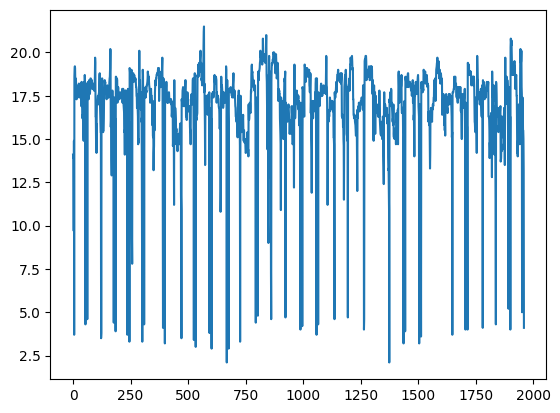

In [56]:
plt.plot(a['T'],a['sog'])

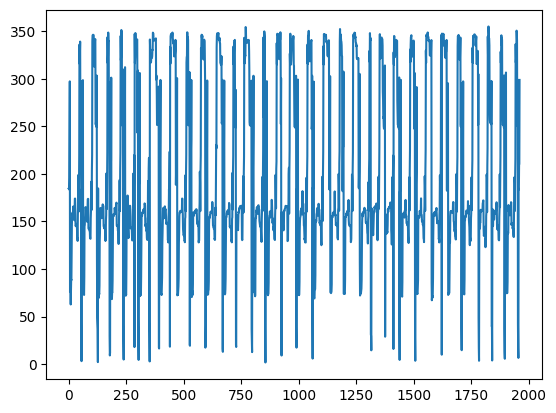

In [50]:
plt.plot(a['T'],a['cog'])

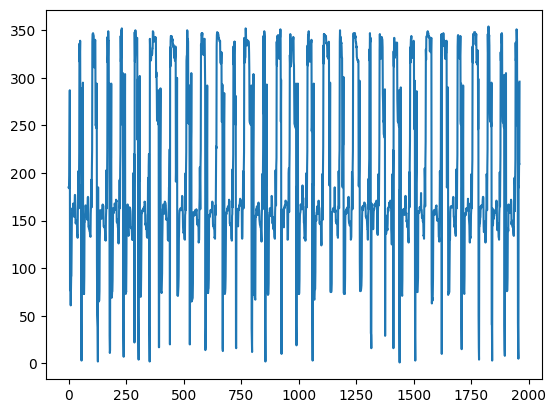

In [51]:
plt.plot(a['T'],a['heading'])

###Pronalazak abnormalnih vrijednosti

In [7]:
#funkcija koja pronalazi broj u nizu s najblizom vrijednoscu onoj koju smo poslali te vraca indeks gdje se u nizu tocno nalazi
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

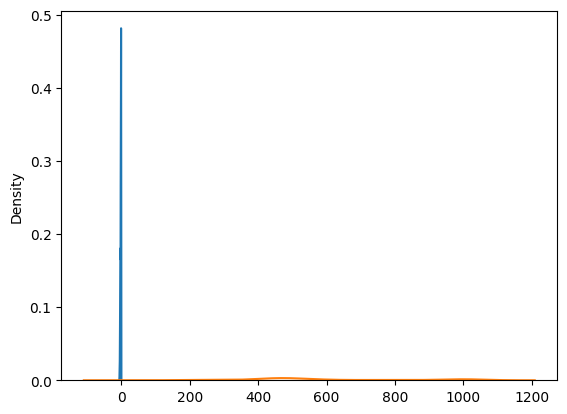

In [8]:
#inicijalizacija
w = 3
T = []
pfsog = [] #sog profil
pfcog = [] #cog profil
pfhd = [] #heading profil
abnormal = [] #lista boolean vrijednosti abnormalnih podataka

for i in range (0,a.shape[0]-w+1): #sliding window algoritam za stvaranje profila
  s=a.sog.iloc[i:i+w].sum()
  c=a.cog.iloc[i:i+w].sum()
  h=a.heading.iloc[i:i+w].sum()
  pfsog.append(s)
  pfcog.append(c)
  pfhd.append(h)

sog_cog_arr = np.array(list(map(lambda i: [pfsog[i],pfcog[i]], range(len(pfsog))))) #uparivanje sog i cog profila
scaler = StandardScaler()
scaler.fit(sog_cog_arr)
pfcog_=scaler.transform(sog_cog_arr) #skaliranje uparenih podataka

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(pfcog_)
sample=kde.score_samples(pfcog_)

z=sns.kdeplot(sample).get_lines()[0].get_data() #iscitavanje vjerojatnosti iz grafa
zh=sns.kdeplot(pfhd).get_lines()[0].get_data()
for wpi in range(1,a.shape[0]-2): #detekcija abnormalnih prozora
  tres_sog_cog=0.1 #granice tj. thresholds
  tres_he=0.0005

  sc_i=sample[wpi]
  hi=a.heading.iloc[wpi]

  index_z=find_nearest_index(z[0],sc_i)
  index_zh=find_nearest_index(zh[0],hi)

  check_z_value=z[1][index_z]
  check_zh_value=zh[1][index_zh]

  if check_z_value<tres_sog_cog or check_zh_value<tres_he:
    ab_behi=True
  else:
    ab_behi=False
  abnormal.append(ab_behi)


###Izdvajanje i dodavanje bitnih vrijednosti

In [9]:
a_mini=a[['mmsi','sog','cog','heading','T']]

In [ ]:
a_mini

,mmsi,sog,cog,heading,T
4682,219945000,14.1,184.7,185.0,0
4712,219945000,13.9,185.0,186.0,1
4716,219945000,14.0,183.7,184.0,2
4812,219945000,9.7,196.3,197.0,3
4889,219945000,14.9,253.6,251.0,4
...,...,...,...,...,...
357952,219945000,15.5,184.4,186.0,1955
357985,219945000,15.5,183.6,185.0,1956
358073,219945000,15.0,210.0,210.0,1957
358114,219945000,13.2,210.2,209.0,1958


In [10]:
std_sog=[]
acc_ch_cog=[]
delta_cog=[]
w2=3
for i in range (0,a_mini.shape[0]-w): #window sliding algoritam za stvaranje novih znacajki
  s_=a_mini.sog.iloc[i:i+w].std()
  c_=a_mini.cog.iloc[i:i+w].sum()
  c2_=abs(a_mini.cog.iloc[i]-a_mini.cog.iloc[i+w])
  std_sog.append(s_)
  acc_ch_cog.append(c_)
  delta_cog.append(c2_)

In [12]:
#dodavanje dopunjenih znacajki u tablicu
a_mini['std_sog']=[0]+std_sog+[0,0]
a_mini['acc_ch_cog']=[0]+acc_ch_cog+[0,0]
a_mini['delta_cog']=[0]+delta_cog+[0,0]
a_mini['abn_adjusted']=[False]+abnormal+[False,False]

/tmp/ipython-input-1780076640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_mini['std_sog']=[0]+std_sog+[0,0]
/tmp/ipython-input-1780076640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_mini['acc_ch_cog']=[0]+acc_ch_cog+[0,0]
/tmp/ipython-input-1780076640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [65]:
a_mini

,mmsi,sog,cog,heading,T,std_sog,acc_ch_cog,delta_cog,abn_adjusted
4682,219945000,14.1,184.7,185.0,0,0.000000,0.0,0.0,False
4712,219945000,13.9,185.0,186.0,1,0.100000,553.4,11.6,False
4716,219945000,14.0,183.7,184.0,2,2.454248,565.0,68.6,False
4812,219945000,9.7,196.3,197.0,3,2.779089,633.6,113.6,True
4889,219945000,14.9,253.6,251.0,4,5.604760,747.2,120.5,False
...,...,...,...,...,...,...,...,...,...
357952,219945000,15.5,184.4,186.0,1955,0.981495,374.6,203.4,False
357985,219945000,15.5,183.6,185.0,1956,0.288675,578.0,25.8,False
358073,219945000,15.0,210.0,210.0,1957,1.209683,603.8,115.2,True
358114,219945000,13.2,210.2,209.0,1958,0.000000,0.0,0.0,False


In [63]:
#mapiranje abnormalnih vrijednosti u boje
d = {True: 'r', False: 'b'}
abn_color = a_mini['abn_adjusted'].replace(d)

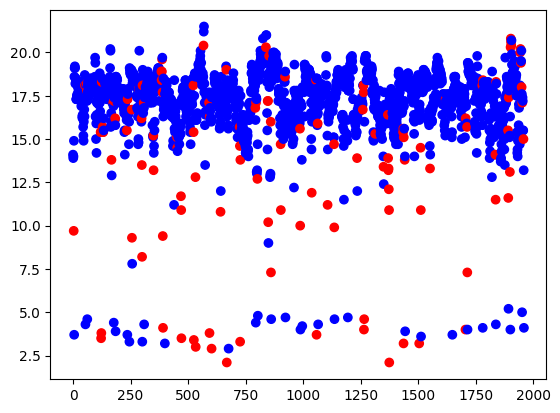

In [72]:
plt.scatter( a_mini['T'],a_mini['sog'], c=abn_color)
plt.show()

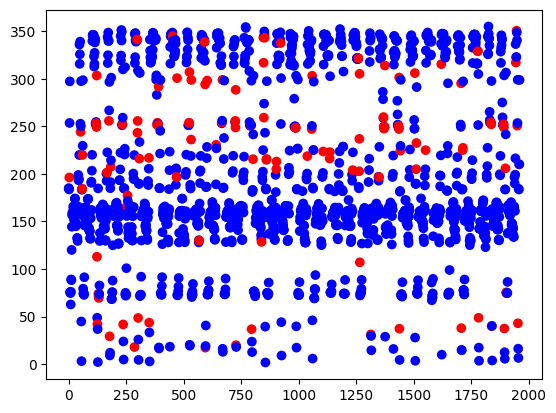

In [73]:
plt.scatter( a_mini['T'],a_mini['cog'], c=abn_color)
plt.show()

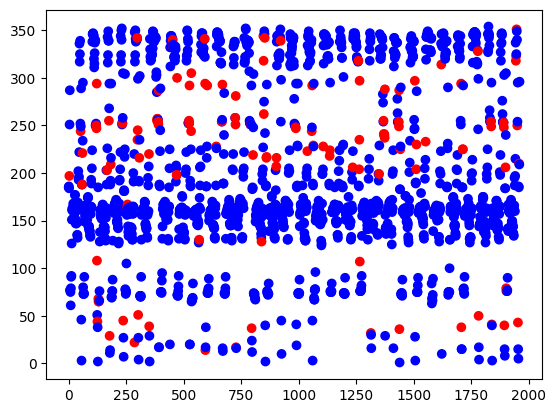

In [74]:
plt.scatter( a_mini['T'],a_mini['heading'], c=abn_color)
plt.show()

###Stabla

In [19]:
X = a_mini.drop(['mmsi','T','abn_adjusted'],axis=1)
y = a_mini['abn_adjusted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [20]:
parameters = {'max_depth': range(3, 20), 'min_samples_leaf': range(2, 30)}
rf = RandomForestClassifier() #definiramo klasifikator
stabla_grid = GridSearchCV(rf, parameters, verbose=2)
stabla_grid.fit(X_train, y_train) #trazimo parametre
print(stabla_grid.best_params_)

Fitting 5 folds for each of 476 candidates, totalling 2380 fits
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.2s
[CV] END ....................max_depth=3, min_samples_leaf=4; total time=   0.2s
[CV] END ....................max_depth=3, min

In [21]:
stablo_rf = RandomForestClassifier(max_depth=11,min_samples_leaf=3)
stablo_rf.fit(X_train, y_train)
y_pred_rf = stablo_rf.predict(X_test)

acc_test = metrics.accuracy_score(y_test, y_pred_rf)
print(f"Točnost na skupu za testiranje: {acc_test*100:.2f}%")

Točnost na skupu za testiranje: 94.39%


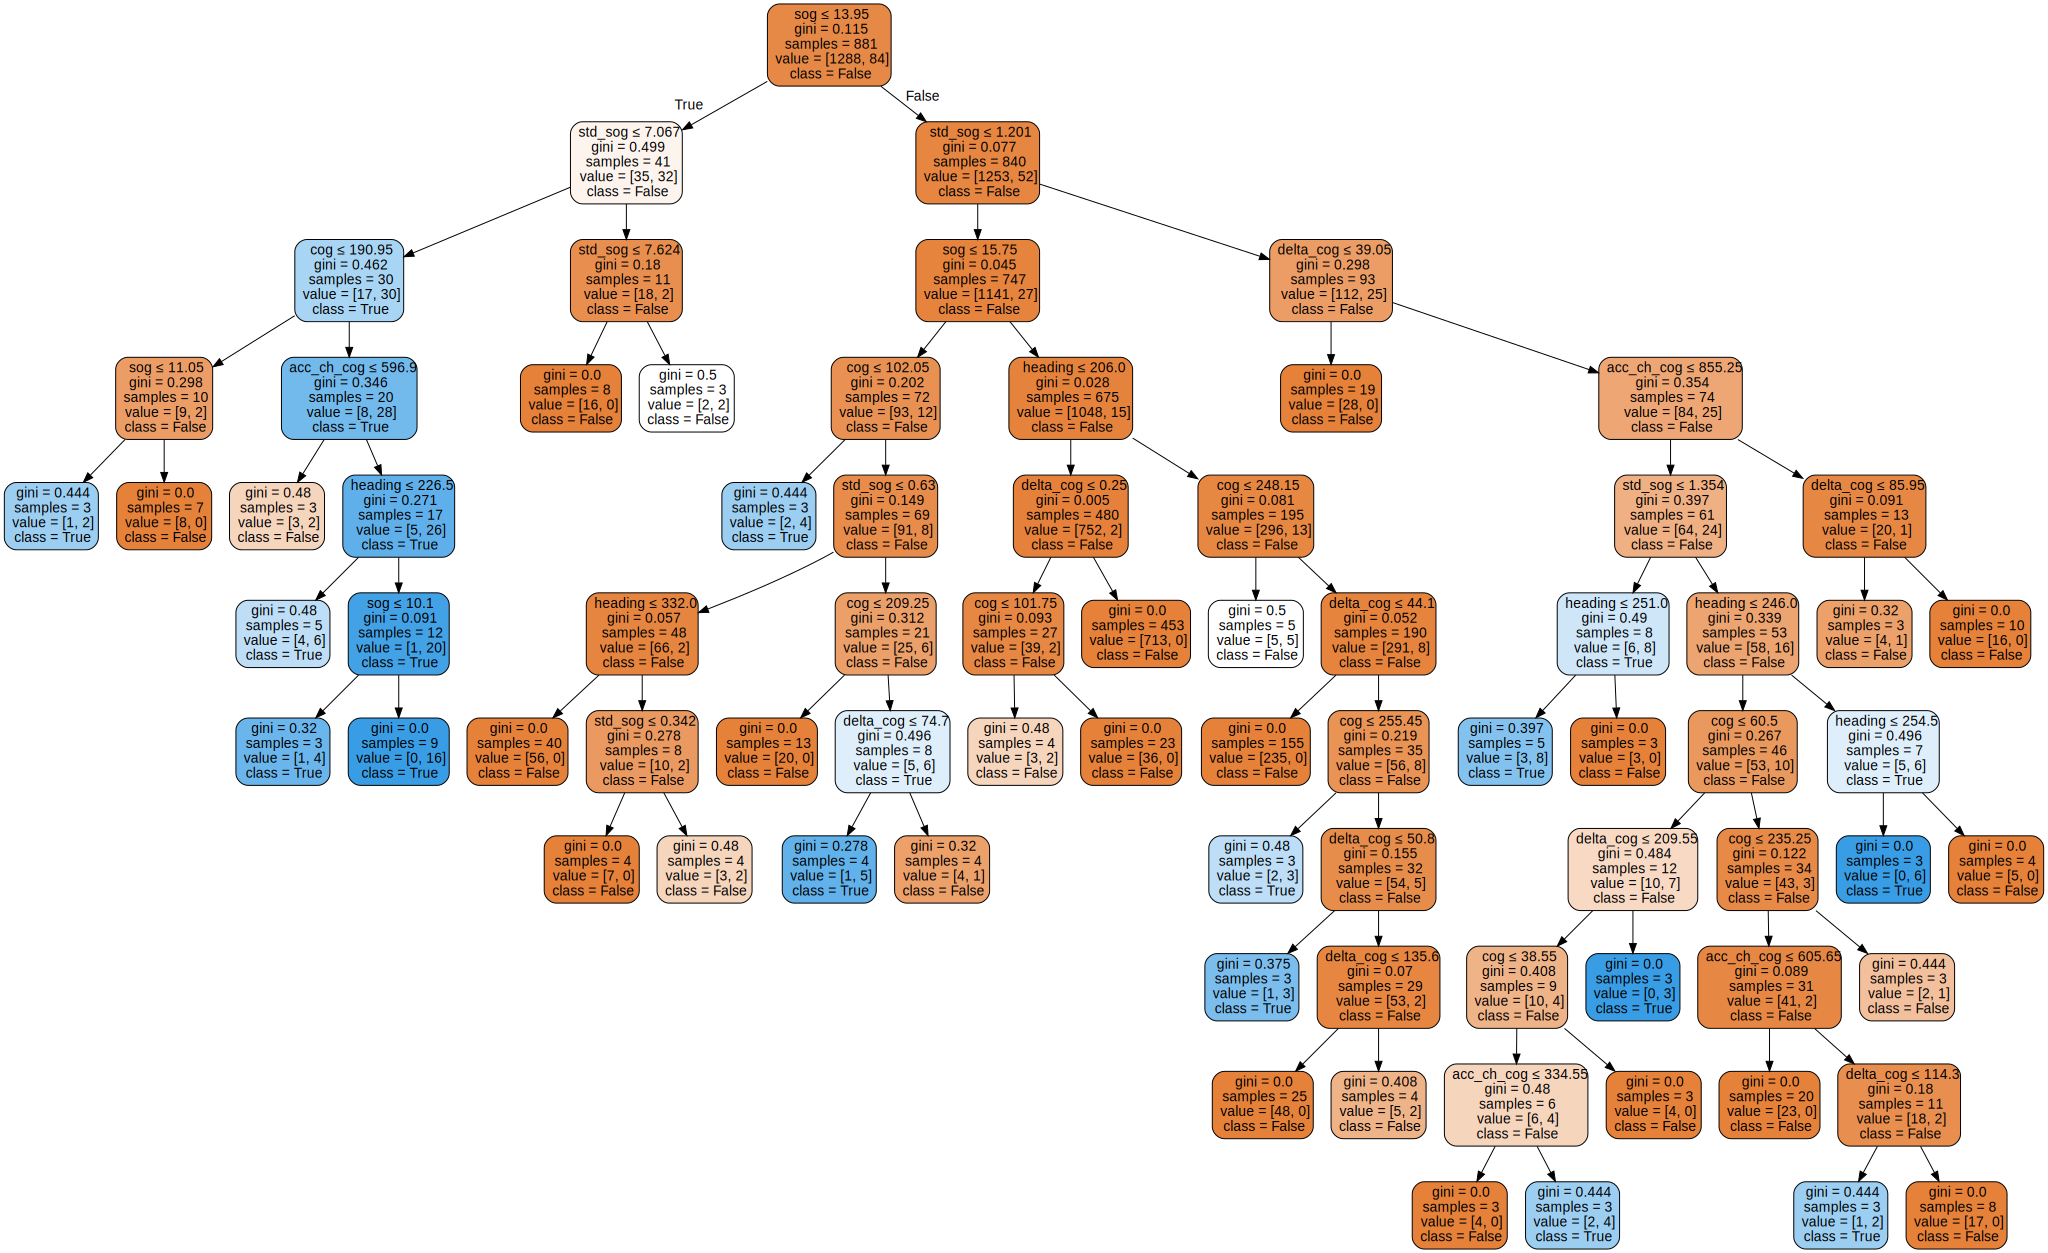

In [22]:
#vizualizacija prvog stabla u sumi
dot_data = tree.export_graphviz(stablo_rf[0],
                                out_file=None,
                                feature_names=X.columns,
                                class_names=y_train.astype(str).unique().tolist(),
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

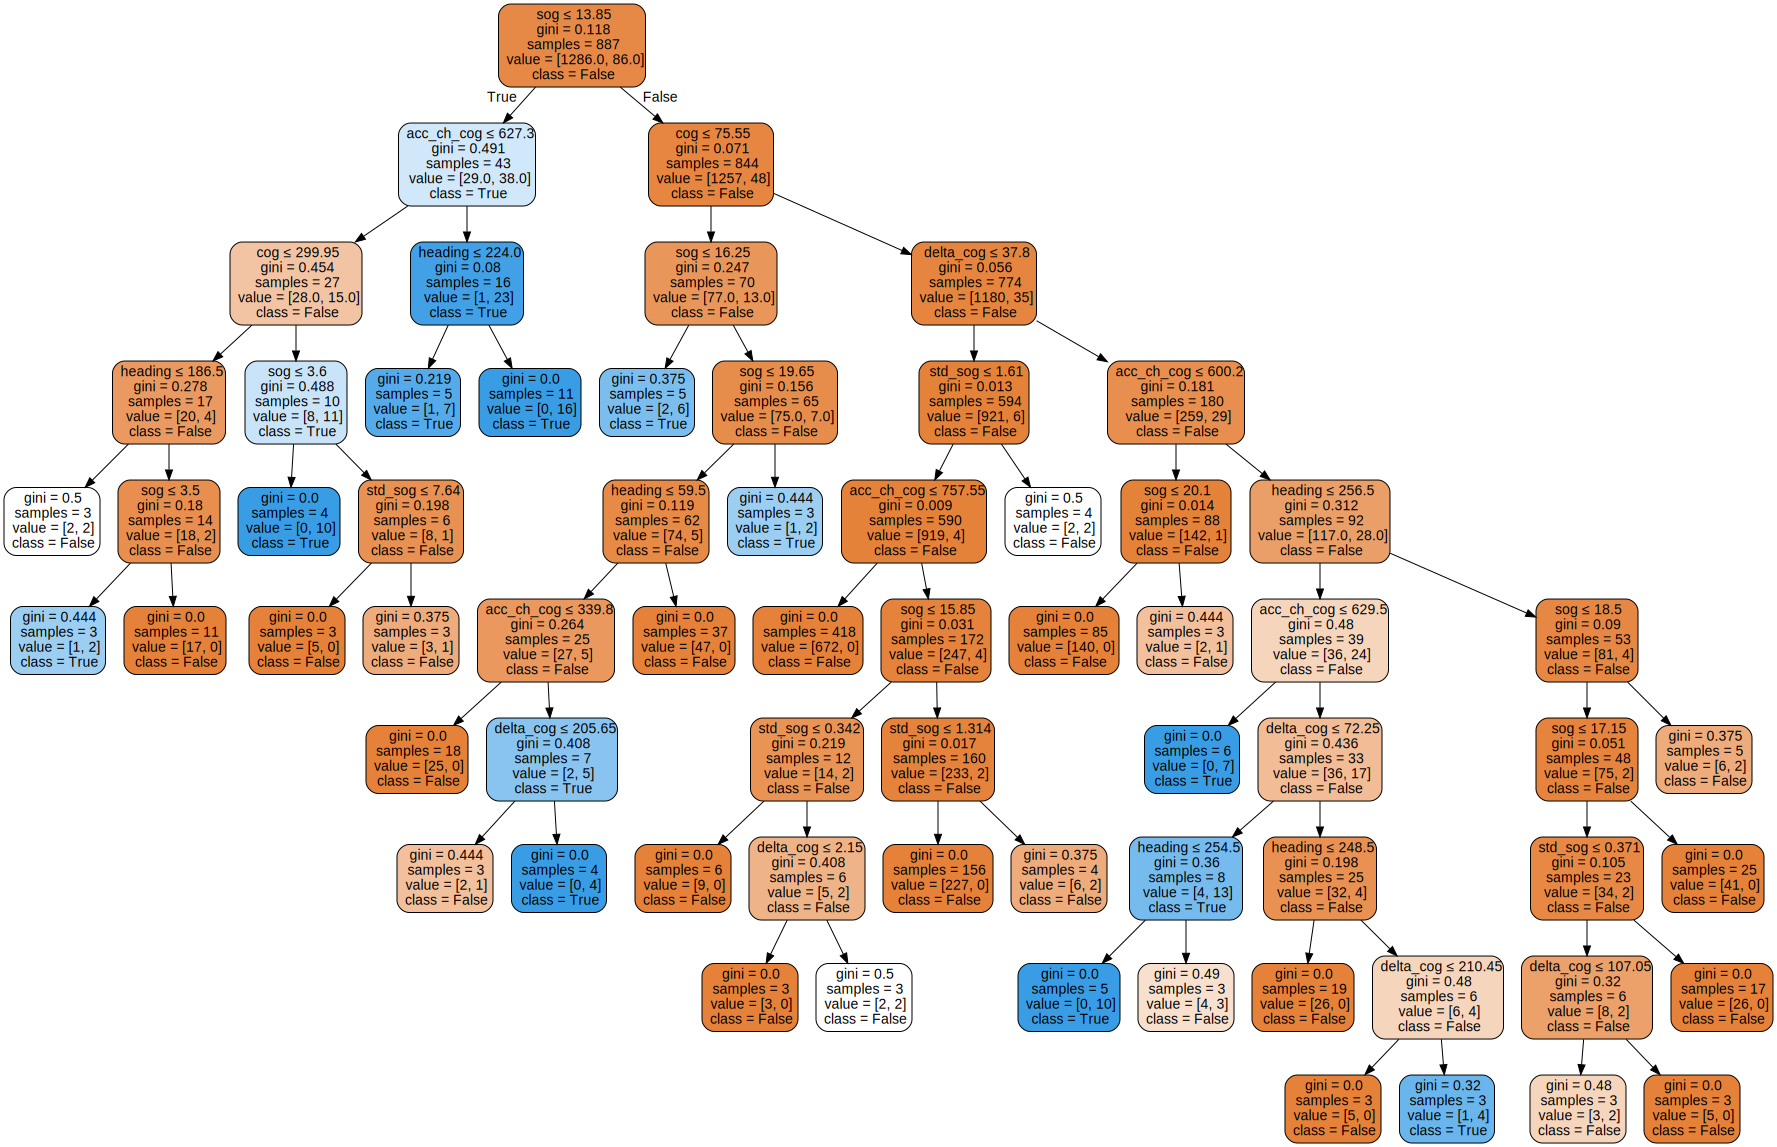

In [25]:
#vizualizacija 51. stabla u sumi
dot_data = tree.export_graphviz(stablo_rf[50],
                                out_file=None,
                                feature_names=X.columns,
                                class_names=y_train.astype(str).unique().tolist(),
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

###Izvori i poveznice

1. https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/

2. https://scikit-learn.org/stable/modules/density.html

3. https://seaborn.pydata.org/generated/seaborn.kdeplot.html

4. https://www.geeksforgeeks.org/machine-learning/kernel-density-estimation/

5. https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517/

6. https://www.geeksforgeeks.org/dsa/window-sliding-technique/

7. https://mega-ecdis.com/knowledge-base/sog

8. https://communities.sas.com/t5/SAS-Communities-Library/Identifying-Anomalous-Frequencies-in-Signal-Data-with-Short-Time/ta-p/891561

9. https://www.sciencedirect.com/science/article/pii/S1877050925016187

10. https://www.govinfo.gov/content/pkg/USCODE-1995-title33/html/USCODE-1995-title33-chap34-subchapI-partC-sec2024.htm


###Dodatne vizualizacije

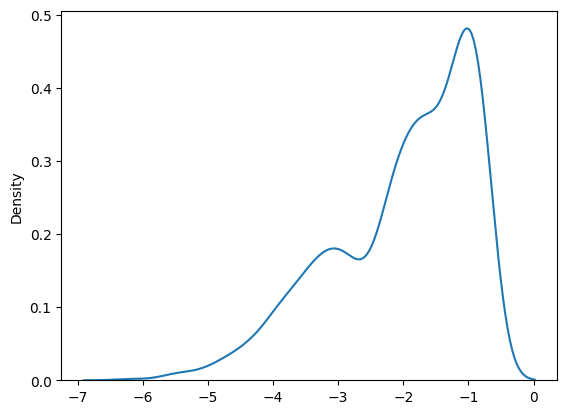

In [76]:
z=sns.kdeplot(sample)#sog_cog density graf za vjerojatnosti -> poglavlje: Pronalazak abnormalnih vrijednosti

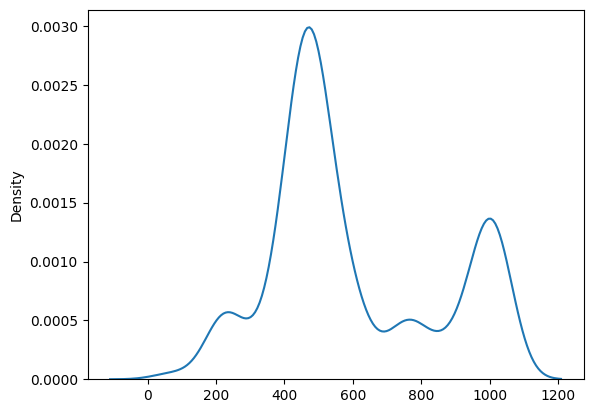

In [77]:
zh=sns.kdeplot(pfhd) #heading density graf za vjerojatnosti -> poglavlje: Pronalazak abnormalnih vrijednosti

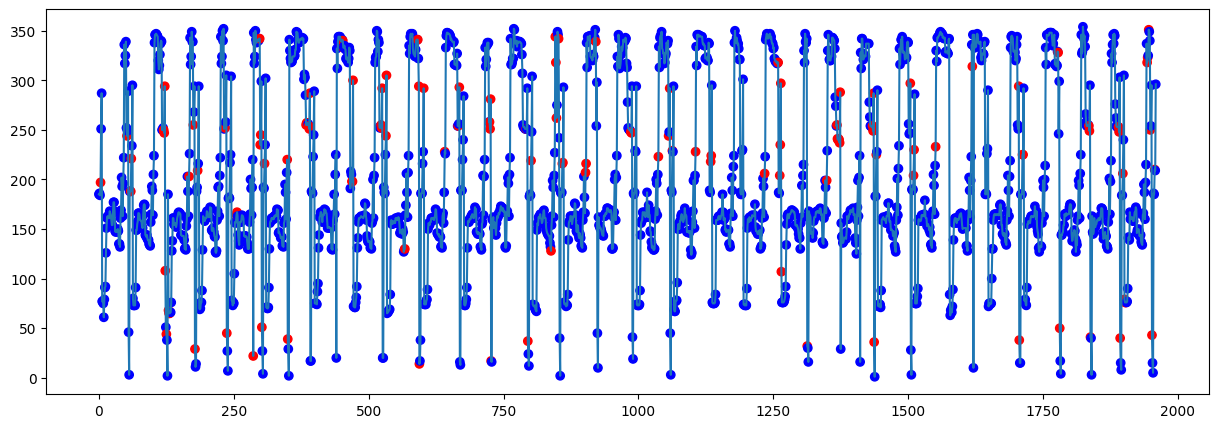

In [104]:
plt.plot(a['T'],a['heading']) #graf ovisnosti headinga o T -> poglavlje Izdvajanje plovila
plt.scatter(a_mini['T'],a_mini['heading'], c=abn_color) #graf ovisnosti headinga o T -> poglavlje Izdvajanje i dodavanje bitnih vrijednosti
plt.rcParams['figure.figsize'] = [17, 5]
plt.show()

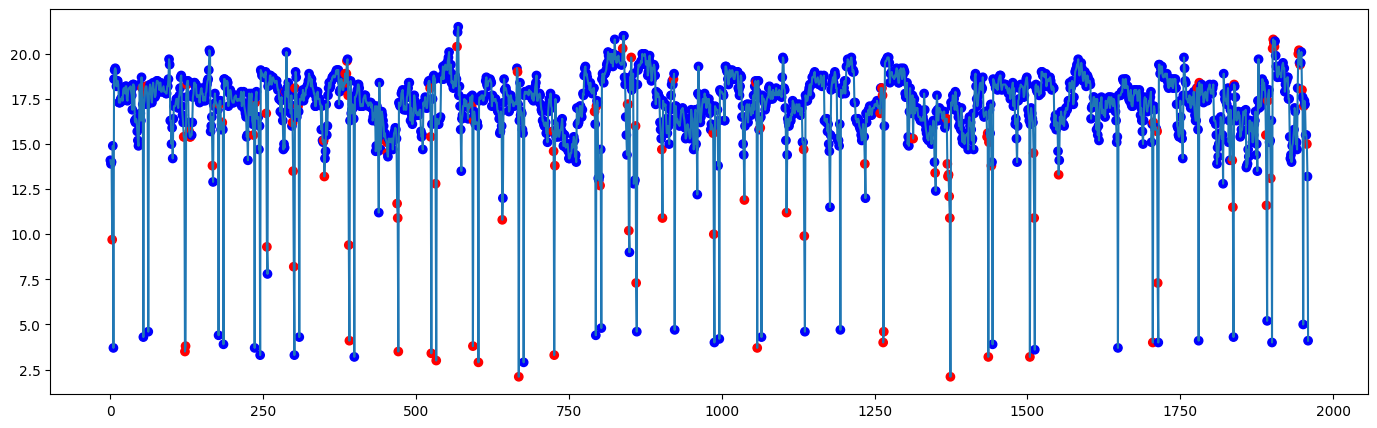

In [105]:
plt.plot(a['T'],a['sog']) #graf ovisnosti SOG-a o T -> poglavlje Izdvajanje plovila
plt.scatter(a_mini['T'],a_mini['sog'], c=abn_color) #graf ovisnosti SOG-a o T -> poglavlje Izdvajanje i dodavanje bitnih vrijednosti
plt.rcParams['figure.figsize'] = [17, 5]
plt.show()

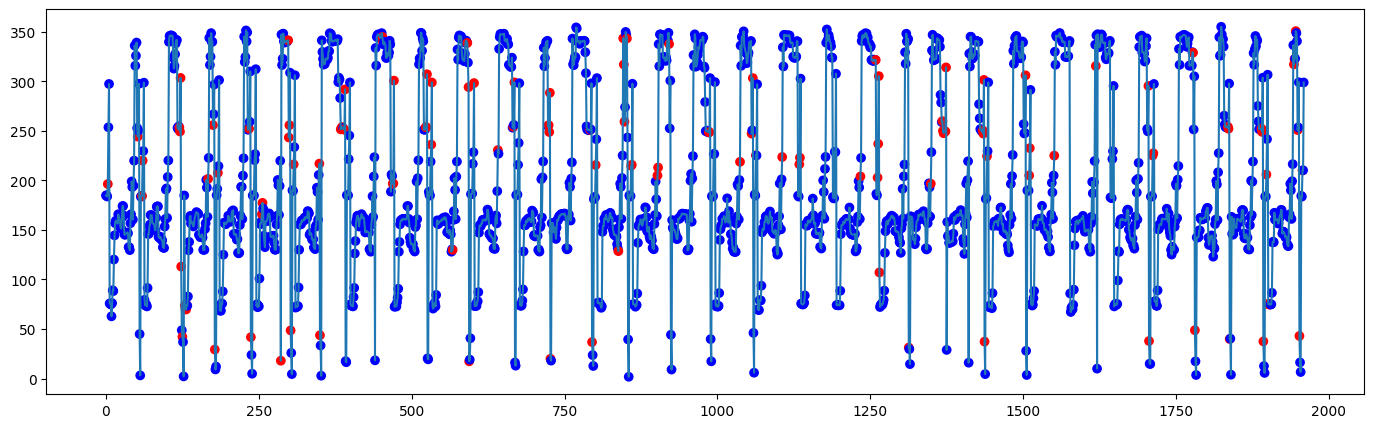

In [106]:
plt.plot(a['T'],a['cog']) #graf ovisnosti COG-a o T -> poglavlje Izdvajanje plovila
plt.scatter(a_mini['T'],a_mini['cog'], c=abn_color) #graf ovisnosti COG-a o T -> poglavlje Izdvajanje i dodavanje bitnih vrijednosti
plt.rcParams['figure.figsize'] = [17, 5]
plt.show()

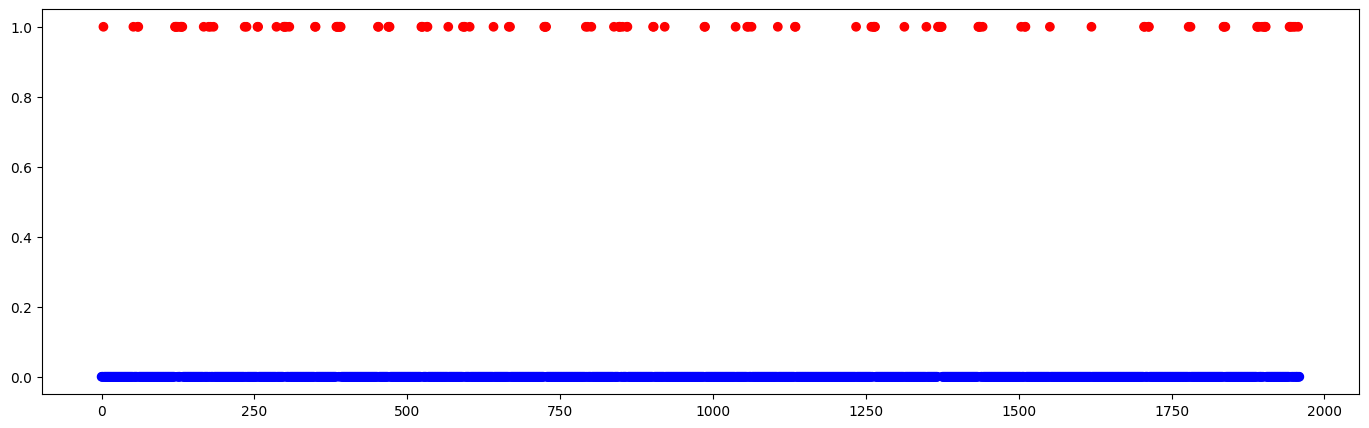

In [111]:
plt.scatter(a_mini['T'],a_mini['abn_adjusted'],c=abn_color) #raspršenost abnormalnih vrijednosti u vremenu

(array([1832.,  128.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

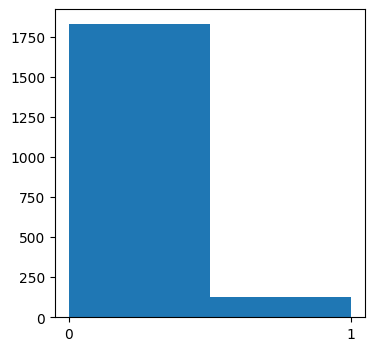

In [113]:
map = {True: '1', False: '0'}
abn_01 = a_mini['abn_adjusted'].replace(map)
plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(abn_01, bins=2) #količina normalnih i abnormalnih vrijednosti

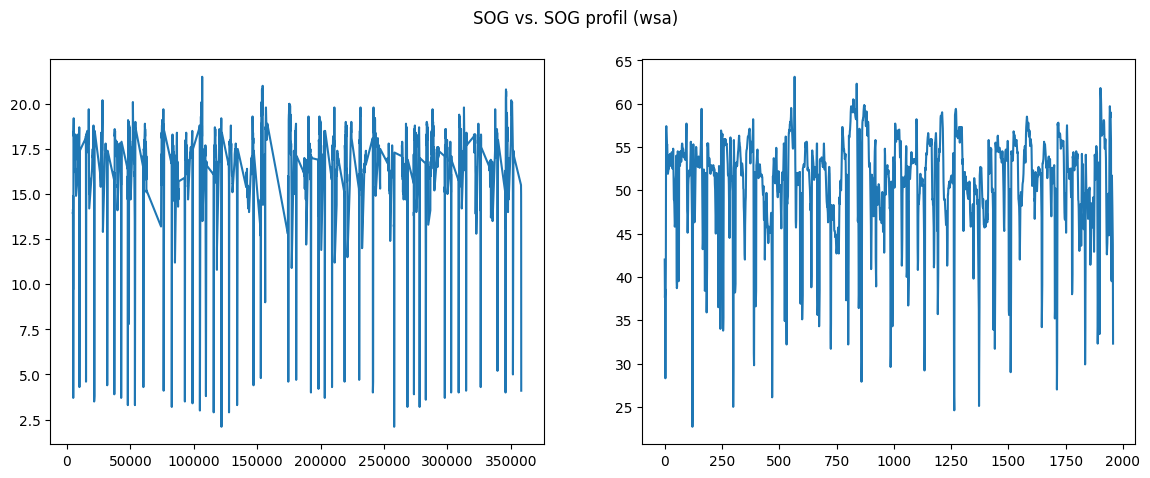

In [122]:
plt.rcParams['figure.figsize'] = [14, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('SOG vs. SOG profil (wsa)')
ax1.plot(a['sog'])
ax2.plot(pfsog)

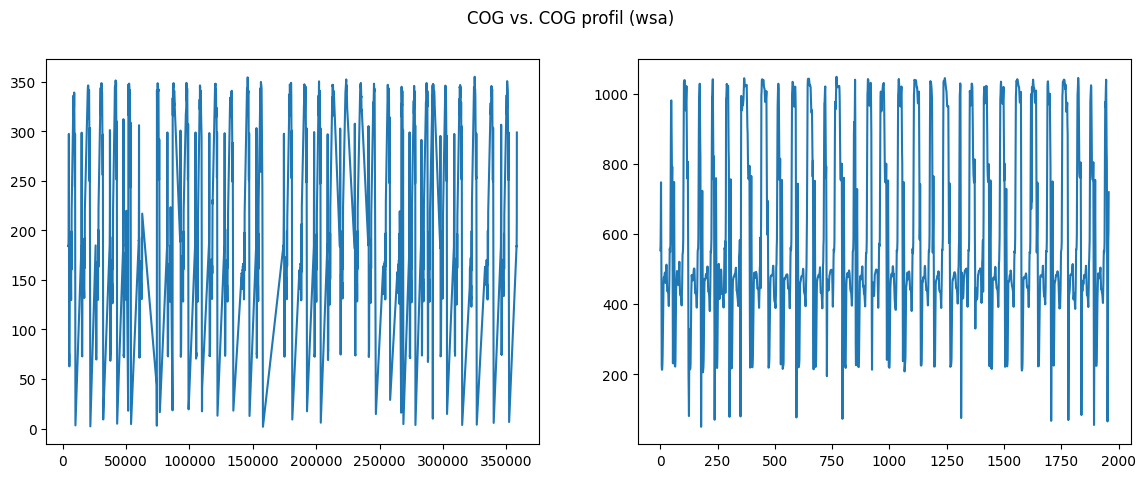

In [123]:
plt.rcParams['figure.figsize'] = [14, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('COG vs. COG profil (wsa)')
ax1.plot(a['cog'])
ax2.plot(pfcog)

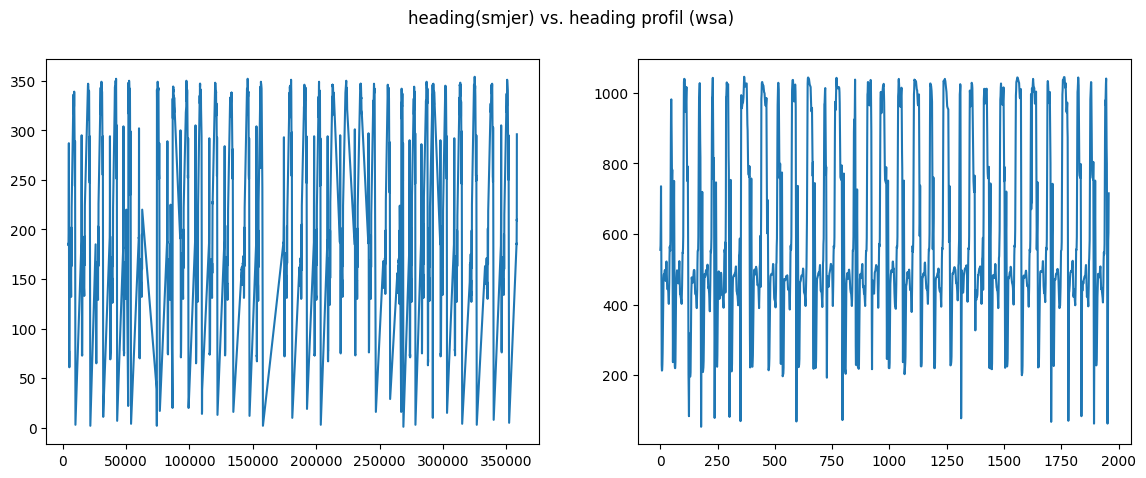

In [124]:
plt.rcParams['figure.figsize'] = [14, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('heading(smjer) vs. heading profil (wsa)')
ax1.plot(a['heading'])
ax2.plot(pfhd)